In [22]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
from matplotlib import cm # import colormap to formulate feature colors
import matplotlib
import scipy.stats as stats
import geopandas as gpd

os.getcwd()
os.chdir('/Users/taopeng/Documents/GIScience2023')

# 1.Data Preprocessing

In [23]:
#pts= pd.read_csv('county/county_2020_020304.csv')
c2020 = pd.read_csv('Data/county_flows_2020.csv')
c2020 = c2020[['geoid', 'date', 'pop_totalflows']]

# select study time
c2020a = c2020
c2020 = c2020[c2020.date < '2020-05-01']
c2020 = c2020[c2020.date > '2020-01-31']

# delete counties not in the US continent
c2020 = c2020[c2020.geoid//1000 != 15] # Hawaii
c2020 = c2020[c2020.geoid//1000 != 2] # Alaska
c2020 = c2020[c2020.geoid//1000 != 72] # Puerto Rico

# c2020.groupby(by = 'geoid').count().reset_index().drop_duplicates(subset='pop_totalflows')
# 8053 16003 30069 30103 do not have data of every day
c2020 = c2020[c2020.geoid != 16033]
c2020 = c2020[c2020.geoid != 8053]
c2020 = c2020[c2020.geoid != 30069]
c2020 = c2020[c2020.geoid != 30103]

# partisanship data
partisanship = pd.read_csv('Data/partisanship_2000_2020.csv')
partisanship = partisanship.rename(columns={'party_idx_16-20': 'partisanship'})

# merge partisanship with mobility data
c2020 = pd.merge(c2020, partisanship, left_on = 'geoid', right_on = 'geoid', how = 'left').dropna()

# average flow of each county
avg_flow = c2020.groupby(by = 'geoid').mean().reset_index()
avg_flow = avg_flow.rename(columns={'pop_totalflows': 'avg_flows'})[['geoid', 'avg_flows']]
# normalize the totalflow by dividing its mean
c2020 = pd.merge(c2020, avg_flow, left_on = 'geoid', right_on = 'geoid', how = 'left')
c2020['scaled_flows'] = c2020['pop_totalflows']/c2020['avg_flows']

/var/folders/6l/52l12h9916z4y7k0qy4pfg0c0000gn/T/ipykernel_82890/1400527423.py:30: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_flow = c2020.groupby(by = 'geoid').mean().reset_index()


# 2.Plot the Travel Volume of Each County

In [24]:
# funciton to plot mobility flow
def PlotFlow (df, id=None, ideology=None, mobility=None, alpha = None, title1 = None, title2 = None, x_tick_gap = 10, y_lim = None, y_scale = None, axis = None): # dataframe, state/county id, ideology

    if axis == None:
        fig, ax = plt.subplots(1, 1, figsize = (10, 3), constrained_layout=True)
        
        for i in df[id].unique():
            df_temp = df[df[id] == i] 
            # formulate ticks
            days = df_temp.date.tolist()[2:]
            x_ticks = days[::x_tick_gap] # select sundays
            # for n, d in enumerate(df_temp.date.tolist()):
            #     if n % x_tick_gap == 0: # display an x-tick every <gap>
            #         x_ticks.append(d)

            if df_temp[ideology].unique() >0 :
                color = 'blue' 
                l1, = ax.plot(df_temp.date.tolist(), df_temp[mobility].tolist(), color = color, alpha = alpha)
            else :
                color = 'red'
                l2, = ax.plot(df_temp.date.tolist(), df_temp[mobility].tolist(), color = color, alpha = alpha) 
            
            ax.set_title(title1)
            ax.set_xticks(x_ticks) # x axis lables
            ax.tick_params(axis="x", labelsize=10)
            ax.tick_params(axis="y", labelsize=10)
        
        avg = c2020.groupby(by='date').mean().reset_index()
        l3, = ax.plot(avg['scaled_flows'], color = 'white', lw=0.5, marker='o',markerfacecolor = 'white', mec='orange', markersize = 2.5)
        ax.legend((l1, l2, l3,), ('Democratic', 'Replublican', 'Average of all counties'), loc='upper right', fontsize = 10)

    else:
        ax = axis
        for i in df[id].unique():
            df_temp = df[df[id] == i] 
            # formulate ticks
            days = df_temp.date.tolist()[2:]
            x_ticks = days[::x_tick_gap] # select sundays
            # for n, d in enumerate(df_temp.date.tolist()):
            #     if n % x_tick_gap == 0: # display an x-tick every <gap>
            #         x_ticks.append(d)

            if df_temp[ideology].unique() >0 :
                color = 'blue' 
                l1, = ax.plot(df_temp.date.tolist(), df_temp[mobility].tolist(), color = color, alpha = alpha)
            else :
                color = 'red'
                l2, = ax.plot(df_temp.date.tolist(), df_temp[mobility].tolist(), color = color, alpha = alpha) 
            
            ax.set_title(title1)
            ax.set_xticks(x_ticks) # x axis lables
            ax.tick_params(axis="x", labelsize=10)
            ax.tick_params(axis="y", labelsize=10)
            ax.set_ylim([0.5, 1.6])
            ax.set_ylabel('Daily mobility volume')
            ax.yaxis.set_label_position("right")
            ax.yaxis.tick_right()
        
        avg = c2020.groupby(by='date').mean().reset_index()
        l3, = ax.plot(avg['scaled_flows'], color = 'white', lw=0.5, marker='o',markerfacecolor = 'white', mec='orange', markersize = 2.5)
        ax.legend((l1, l2, l3,), ('Democratic county', 'Replublican county', 'Average of all 3101 counties'), loc='upper right', fontsize = 10)


    if title2 != None:
        fig.savefig(title2, format='png', dpi=200)

In [25]:
# randomly sample 300 red counties and 300 blue counties
import random

red_county = c2020[c2020['partisanship'] < -0.15].geoid.unique().tolist()
blue_county = c2020[c2020['partisanship'] > 0.15].geoid.unique().tolist()
red_county = random.sample(red_county, k=100)
blue_county = random.sample(blue_county, k=100)
random_county = red_county + blue_county
random_county = c2020.loc[c2020.geoid.isin(random_county)].sort_values(by = ['geoid', 'date'])

/var/folders/6l/52l12h9916z4y7k0qy4pfg0c0000gn/T/ipykernel_82890/2373917477.py:28: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg = c2020.groupby(by='date').mean().reset_index()


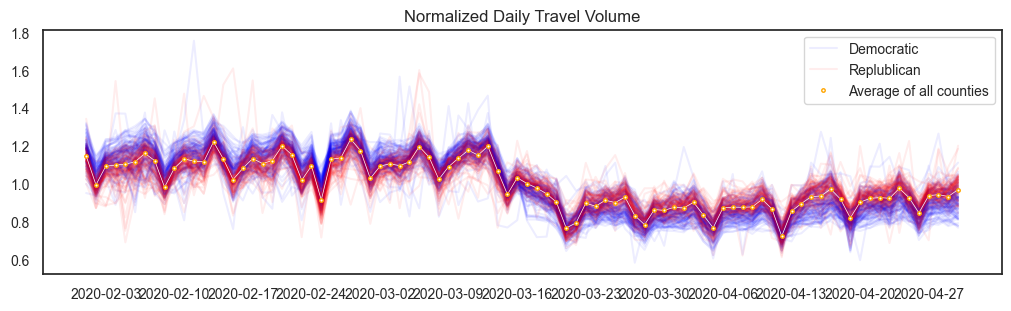

In [26]:
PlotFlow(random_county, id='geoid', ideology='partisanship', mobility='scaled_flows', alpha = 0.07, title1 = 'Normalized Daily Travel Volume', x_tick_gap = 7)

# 3.Structural Break Analysis

In [27]:
import matplotlib.pyplot as plt
import ruptures as rpt

# sort the values
c2020 = c2020.sort_values(by = ['geoid','date'], ascending = True)
# date
geoid = c2020.geoid.unique()
# counties
date = c2020.date.unique()

county_break0 = [] # no break point
county_break1 = [] # 1 break point
county_break2 = [] # 2 break points
county_break3 = []


for i in geoid:
    # flows as an array
    df_tmp = c2020[c2020.geoid == i]  
    y = np.array(df_tmp['scaled_flows'].tolist())
    
    # detection
    algo = rpt.Pelt(model="rbf").fit(y)
    result = algo.predict(pen=10)
    
    # assign county and the break point date to a list
    if len(result) == 1:
        county_break0.append([i])
    elif len(result) == 2:
        county_break1.append([i, result[0]-1, date[result[0]-1]]) # because result count from 1, so the corresponding date is date[result[0]-1]
    elif len(result) == 3:
        county_break2.append([i, result[0]-1, date[result[0]-1], result[1]-1, date[result[1]-1]])
    else:
        county_break3.append([i, result[0]-1, date[result[0]-1], result[1]-1, date[result[1]-1], result[2]-1, date[result[2]-1]])


In [28]:
print(len(county_break0))
print(len(county_break1))
print(len(county_break2))
print(len(county_break3))

a = pd.DataFrame(data=county_break1,columns=['geoid', 'day1', 'date1'])
a.groupby(by='date1').count()

165
2936
0
0


,geoid,day1
date1,,
2020-03-01,2,2
2020-03-06,3,3
2020-03-11,71,71
2020-03-16,2748,2748
2020-03-21,112,112


## Calculating intercept, slope, mean difference

In [29]:
from sklearn.linear_model import LinearRegression

# list of list to save intercept difference and slope difference
result = []

for item in np.array(county_break1):
    
    # item[0]: county geoid, item[1]: break point 1, item[2]: break point 2...
    df_tmp = c2020[c2020.geoid == int(item[0])]
    # assign 0,1,2,3...to date
    n = len(c2020.date.unique())
    date = list(range(0, n))
    dates = np.array(date).reshape((-1,1))

    # scaled_flows as list
    y = df_tmp['scaled_flows'].tolist()
    total_before = np.array(y[0:int(item[1])]) # date before break point
    total_after = np.array(y[int(item[1]):n]) # date after break point
    date_before = np.array(list(range(0,int(item[1])))).reshape((-1, 1)) # flows before break point
    date_after = np.array(list(range(int(item[1]),n))).reshape((-1, 1)) # flows after break point
    
    # linear regression
    model = LinearRegression().fit(dates, y) # entire data
    model_before = LinearRegression().fit(date_before, total_before)
    model_after = LinearRegression().fit(date_after, total_after)
    # intercept difference
    intercept_diff = model_after.intercept_ - model_before.intercept_
    # slope difference
    slope_diff = model_after.coef_[0] - model_before.coef_[0]
    # mean travel volume difference
    mean_diff = total_after.mean() - total_before.mean()
    # append to the list result
    result.append([int(item[0]), df_tmp.partisanship.tolist()[0], float(intercept_diff), float(slope_diff), float(mean_diff), model_after.coef_[0], model_before.coef_[0]])

result = pd.DataFrame(result, columns = ['geoid', 'partisanship', 'intercept_diff', 'slope_diff', 'mean_diff', 'slope_after', 'slope_before'])

## visualization

/var/folders/6l/52l12h9916z4y7k0qy4pfg0c0000gn/T/ipykernel_82890/1265390594.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['dates'] = dates


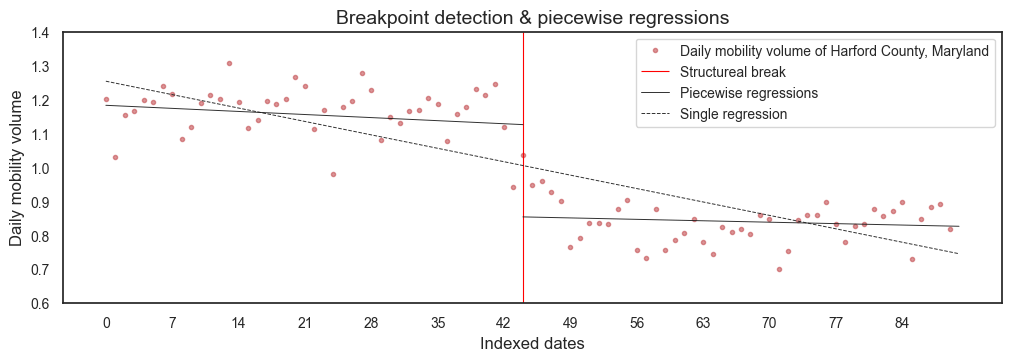

In [30]:
from sklearn.linear_model import LinearRegression
a = c2020[c2020.geoid==24025]

# 24025
y = a['scaled_flows'].tolist()
n = len(a.date.unique())
date = list(range(0, n))
dates = np.array(date).reshape((-1,1))
total_before = np.array(y[0:44]) # date before break point
total_after = np.array(y[45:90]) # date after break point
date_before = np.array(list(range(0,44))).reshape((-1, 1)) # flows before break point
date_after = np.array(list(range(45,90))).reshape((-1, 1)) # flows after break point
a['dates'] = dates
model = LinearRegression().fit(dates, y) # entire data
model_before = LinearRegression().fit(date_before, total_before)
model_after = LinearRegression().fit(date_after, total_after)

fig,ax = plt.subplots(1,1,figsize = (10, 3.5), constrained_layout = True)
ax.plot(a.dates, a.scaled_flows, 'or', markersize = 3, alpha = 0.6, label = 'Daily mobility volume of Harford County, Maryland')

days = a.dates.tolist()
x_ticks = days[::7] # select sundays
img = ax.set_xticks(x_ticks)
img = ax.tick_params(axis="x", labelsize=10)
img = ax.tick_params(axis="y", labelsize=10)

# draw the regression line
x = np.array([0,89])
ax.vlines(44, 0.6, 1.4, color = 'red',  linewidth = 0.8, label = 'Structureal break')
#ax.plot(np.array([44]), a[a.dates==44].scaled_flows, 'o', color = 'orange', linewidth = 3, alpha = 0.8, label = 'Structural breakpoint')

ax.plot(np.array([0,44]), model_before.coef_[0] * x + model_before.intercept_, '-k', linewidth = 0.7, alpha = 0.9, label = 'Piecewise regressions')
ax.plot(np.array([0,90]), model.coef_[0] * x + model.intercept_, '--k', linewidth = 0.7, alpha = 0.9, label = 'Single regression')
ax.plot(np.array([44,90]), model_after.coef_[0] * x + model_after.intercept_, '-k', linewidth = 0.7, alpha = 0.9)
ax.set_xlabel('Indexed dates')
ax.set_ylabel('Daily mobility volume')

ax.set_ylim(0.6, 1.4)
ax.legend(fontsize = 10)
ax.set_title('Breakpoint detection & piecewise regressions', fontsize = 14)

fig.savefig('piece-wise regression.png', format = 'png', dpi = 300)

/var/folders/6l/52l12h9916z4y7k0qy4pfg0c0000gn/T/ipykernel_82890/2373917477.py:59: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg = c2020.groupby(by='date').mean().reset_index()


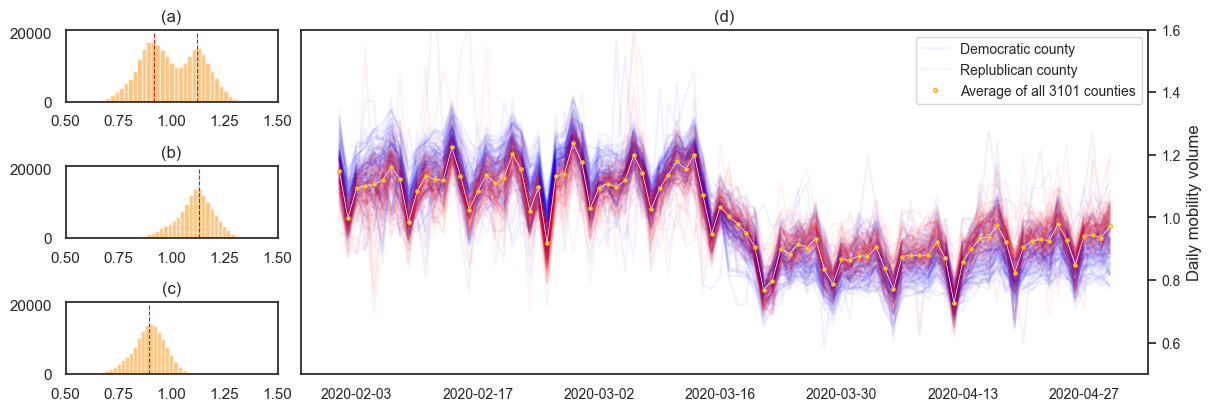

In [31]:
fig, axd = plt.subplot_mosaic([['left1', 'right','right', 'right', 'right'],\
                               ['left2', 'right','right', 'right', 'right'],\
                               ['left3', 'right','right', 'right', 'right']],
                               figsize = (12, 4),
                              constrained_layout=True)
img = axd['left1']. hist(c2020.scaled_flows, bins=70, color = 'darkorange', alpha = 0.5, histtype='bar', ec='white')
img = axd['left2']. hist(c2020[c2020.date < '2020-03-16'].scaled_flows, bins=70, color = 'darkorange', alpha = 0.5, histtype='bar', ec='white')
img = axd['left3']. hist(c2020[c2020.date > '2020-03-16'].scaled_flows, bins=70, color = 'darkorange', alpha = 0.5, histtype='bar', ec='white')

img = axd['left1'].set_xlim([0.5,1.5])
img = axd['left2'].set_xlim([0.5,1.5])
img = axd['left3'].set_xlim([0.5,1.5])

img = axd['left1'].vlines(0.915, 0, 20000, color = 'red', linestyles='dashed', linewidth = 0.8)
img = axd['left1'].vlines(1.12, 0, 20000, color = 'red', linestyles='dashed', linewidth = 0.8)
img = axd['left2'].vlines(1.13, 0, 20000, color = 'red', linestyles='dashed', linewidth = 0.8)
img = axd['left3'].vlines(0.895, 0, 20000, color = 'red', linestyles='dashed', linewidth = 0.8)

img = axd['left1'].set_title('(a)')
img = axd['left2'].set_title('(b)')
img = axd['left3'].set_title('(c)')

PlotFlow(random_county, id='geoid', ideology='partisanship', mobility='scaled_flows', alpha = 0.05, title1 = '(d)', x_tick_gap = 14, axis=axd['right'])

# breakpoints
a = pd.DataFrame(data=county_break1,columns=['geoid', 'day1', 'date1'])
b = a.groupby(by='date1').count().reset_index()
c = c2020.drop_duplicates(subset=['date'])[['date']]
d = pd.merge(b,c,left_on = 'date1', right_on = 'date', how = 'right')

fig.savefig('scaled_mobility_2020_2.png', format = 'png', dpi =300)


# 4.T test

In [32]:
import pandas as pd
import researchpy as rp
import scipy.stats as stats

def t_test (df, partisanship = 'partisanship', parameter=None, parti1=None, parti2=None, name1=None, name2=None, psummary = False): 

    # t test
    summary, results = rp.ttest(group1 = df[df[partisanship] > parti1][parameter], group1_name= name1,
                                group2 = df[df[partisanship] < parti2][parameter], group2_name= name2)
    if psummary is True:
        print(summary)
        print(results)
    else:
        print(results)

In [33]:
df = result 

# deep blue and deep red
#t_test(df, parameter='intercept_diff', parti1= 0.15, parti2 = -0.15, name1='Democratic', name2='Republican', psummary = True)
#t_test(df, parameter='slope_diff', parti1= 0.15, parti2 = -0.15, name1='Democratic', name2='Republican', psummary = True)
# t_test(df, parameter='mean_diff', parti1= 0.15, parti2 = -0.15, name1='Democratic', name2='Republican', psummary = True)

# # blue and red
#t_test(df, parameter='intercept_diff', parti1= 0, parti2 = 0, name1='Democratic', name2='Republican', psummary = True)
#t_test(df, parameter='slope_diff', parti1= 0, parti2 = 0, name1='Democratic', name2='Republican', psummary = True)
# t_test(df, parameter='mean_diff', parti1= 0, parti2 = 0, name1='Democratic', name2='Republican', psummary = True)

t_test(df, parameter='slope_before', parti1= 0, parti2 = 0, name1='Democratic', name2='Republican', psummary = True)
t_test(df, parameter='slope_after', parti1= 0, parti2 = 0, name1='Democratic', name2='Republican', psummary = True)



     Variable       N      Mean        SD        SE  95% Conf.  Interval
0  Democratic   495.0 -0.000226  0.001076  0.000048  -0.000321 -0.000131
1  Republican  2441.0  0.000298  0.000836  0.000017   0.000265  0.000331
2    combined  2936.0  0.000210  0.000902  0.000017   0.000177  0.000243
                        Independent t-test    results
0  Difference (Democratic - Republican) =     -0.0005
1                    Degrees of freedom =   2934.0000
2                                     t =    -12.0635
3                 Two side test p value =      0.0000
4                Difference < 0 p value =      0.0000
5                Difference > 0 p value =      1.0000
6                             Cohen's d =     -0.5947
7                             Hedge's g =     -0.5945
8                        Glass's delta1 =     -0.4868
9                      Point-Biserial r =     -0.2174
     Variable       N      Mean        SD        SE  95% Conf.  Interval
0  Democratic   495.0  0.000077  0.000889

/Users/taopeng/Library/Python/3.9/lib/python/site-packages/researchpy/ttest.py:38: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  groups = group1.append(group2, ignore_index= True)
/Users/taopeng/Library/Python/3.9/lib/python/site-packages/researchpy/ttest.py:38: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  groups = group1.append(group2, ignore_index= True)


In [34]:
import scipy
red_df = result.loc[result.partisanship < -0.15]
purple_df = result.loc[result.partisanship.abs() < 0.15]
blue_df = result.loc[result.partisanship > 0.15]

print(scipy.stats.ttest_ind(red_df.slope_before, blue_df.slope_before))
print(scipy.stats.ttest_ind(red_df.slope_after, blue_df.slope_after))
print(scipy.stats.ttest_ind(red_df.mean_diff, blue_df.mean_diff))
print(scipy.stats.ttest_ind(blue_df.slope_before, purple_df.slope_before))
print(scipy.stats.ttest_ind(blue_df.slope_after,  purple_df.slope_after))
print(scipy.stats.ttest_ind(blue_df.mean_diff,  purple_df.mean_diff))
print(scipy.stats.ttest_ind(red_df.slope_before, purple_df.slope_before))
print(scipy.stats.ttest_ind(red_df.slope_after,  purple_df.slope_after))
print(scipy.stats.ttest_ind(red_df.mean_diff,  purple_df.mean_diff))
print()
print(red_df.slope_before.mean(), purple_df.slope_before.mean(), blue_df.slope_before.mean())
print(red_df.slope_after.mean(), purple_df.slope_after.mean(), blue_df.slope_after.mean())
print(red_df.mean_diff.mean(), purple_df.mean_diff.mean(), blue_df.mean_diff.mean())

Ttest_indResult(statistic=11.729169502270157, pvalue=6.083260746117877e-31)
Ttest_indResult(statistic=14.642171139469403, pvalue=1.3842042639564807e-46)
Ttest_indResult(statistic=22.377934784112067, pvalue=5.429740756701658e-101)
Ttest_indResult(statistic=-5.007602173388535, pvalue=6.822504973489267e-07)
Ttest_indResult(statistic=-5.950345849307811, pvalue=4.044035858254419e-09)
Ttest_indResult(statistic=-5.230346528293637, pvalue=2.1768696045819964e-07)
Ttest_indResult(statistic=7.103160305646569, pvalue=1.5585105362769096e-12)
Ttest_indResult(statistic=10.475069988880751, pvalue=3.4489715694014345e-25)
Ttest_indResult(statistic=17.413838669018222, pvalue=2.103393859237837e-64)

0.00032244101258443965 2.8289310834862193e-05 -0.00034339204546647535
0.0007162636763381894 0.0002974613717756471 -7.457115191298211e-05
-0.20470198115683974 -0.24573765676674603 -0.27472612884129965


# 5.Regression

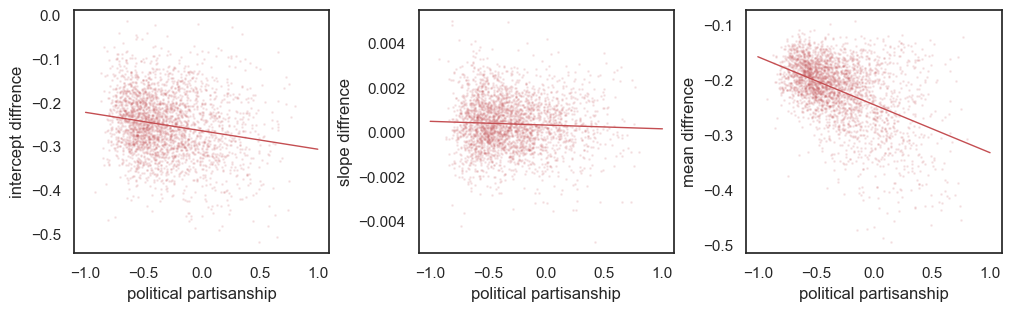

In [35]:
# plot the result

fig,ax = plt.subplots(1,3, figsize = (10,3), constrained_layout = True, sharex=True)
ax[0].scatter(result.partisanship, result.intercept_diff,  color = 'r', alpha = 0.1, s = 1)
ax[1].scatter(result.partisanship, result.slope_diff,  color = 'r', alpha = 0.1, s = 1)
ax[2].scatter(result.partisanship, result.mean_diff,  color = 'r', alpha = 0.1, s = 1)
ax[0].set_ylabel('intercept diffrence')
ax[0].set_xlabel('political partisanship')
ax[1].set_ylabel('slope diffrence')
ax[1].set_xlabel('political partisanship')
ax[2].set_ylabel('mean diffrence')
ax[2].set_xlabel('political partisanship')

# linear regression partisanship -
df = result
# intercept difference
LR_interceptDiff = LinearRegression().fit(np.array(df.partisanship).reshape(-1,1), np.array(df.intercept_diff).reshape(-1,1))
# slope difference
LR_slopeDiff = LinearRegression().fit(np.array(df.partisanship).reshape(-1,1), np.array(df.slope_diff).reshape(-1,1))
# mean difference
LR_meanDiff = LinearRegression().fit(np.array(df.partisanship).reshape(-1,1), np.array(df.mean_diff).reshape(-1,1))

# draw the regression line
x = np.array([-1,1])
ax[0].plot(np.array([-1,1]), LR_interceptDiff.coef_[0][0] * x + LR_interceptDiff.intercept_[0], '-r', linewidth = 1)
ax[1].plot(np.array([-1,1]), LR_slopeDiff.coef_[0][0] * x + LR_slopeDiff.intercept_[0], '-r', linewidth = 1)
ax[2].plot(np.array([-1,1]), LR_meanDiff.coef_[0][0] * x + LR_meanDiff.intercept_[0], '-r', linewidth = 1)

In [36]:
TVD = pd.DataFrame(index = (['Rep.', 'Swi.', 'Dem.']), columns= (['Dem.', 'Swi.', 'Rep.']))
BBS = pd.DataFrame(index = (['Rep.', 'Swi.', 'Dem.']), columns= (['Dem.', 'Swi.', 'Rep.']))
ABS = pd.DataFrame(index = (['Rep.', 'Swi.', 'Dem.']), columns= (['Dem.', 'Swi.', 'Rep.']))
ABS1 = pd.DataFrame(index = (['Rep.', 'Swi.', 'Dem.']), columns= (['Dem.', 'Swi.', 'Rep.']))
ABS2 = pd.DataFrame(index = (['Rep.', 'Swi.', 'Dem.']), columns= (['Dem.', 'Swi.', 'Rep.']))

TVD['Dem.']= [0.000, 0.000, 1.000]
TVD['Swi.']= [0.000, 1.000, 0.000]
TVD['Rep.']= [1.000, 0.000, 0.000]

BBS['Dem.']= [0.000, 0.000, 1.000]
BBS['Swi.']= [0.000, 1.000, 0.000]
BBS['Rep.']= [1.000, 0.000, 0.000]

ABS['Dem.']= [0.000, 0.000, 1.000]
ABS['Swi.']= [0.000, 1.000, 0.000]
ABS['Rep.']= [1.000, 0.000, 0.0000]

ABS1['Dem.']= [0.000, 0.5377, 1.000]
ABS1['Swi.']= [0.000, 1.000, 0.5377]
ABS1['Rep.']= [1.000, 0.000, 0.000]

ABS2['Dem.']= [0.000, 0.7633, 1.000]
ABS2['Swi.']= [0.000, 1.000, 0.7633]
ABS2['Rep.']= [1.000, 0.000, 0.000]

annot_labels02 = np.array([['','','-0.003'],
                         ['','-0.0024',''],
                         ['-0.004','','']])
annot_labels03 = np.array([['','','-0.0111'],
                         ['','-0.0127',''],
                         ['-0.0117','','']])
annot_labels01 = np.array([['','','-0.2054'],
                         ['','-0.2368',''],
                         ['-0.2496','','']])

annot_labels12 = np.array([['','','-0.0004'],
                         ['','-0.0002',''],
                         ['-0.0017','','']])
annot_labels13 = np.array([['','','-0.0063'],
                         ['','-0.0068',''],
                         ['-0.0067','','']])
annot_labels11 = np.array([['','','-0.2154'],
                         ['','-0.2508',''],
                         ['-0.2701','','']])

annot_labels22 = np.array([['','','-0.0002'],
                         ['','-0.0005',''],
                         ['-0.0013','','']])
annot_labels23 = np.array([['','','-0.0038'],
                         ['','-0.004',''],
                         ['-0.004','','']])
annot_labels21 = np.array([['','','-0.2233'],
                         ['','-0.2595',''],
                         ['-0.2804','','']])

In [37]:

mask = np.array(
    [[ True,  True,  False],
       [True,  False,  False],
       [False, False,  False]]
       )

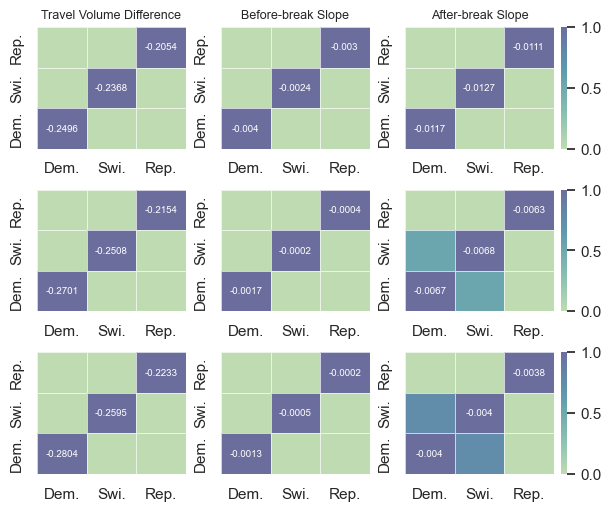

In [38]:
import seaborn as sns

fig, ax = plt.subplots(3,3, figsize=(6, 5), constrained_layout = True)

ax[0,0].set_title('Travel Volume Difference', fontsize = 9)
ax[0,1].set_title('Before-break Slope', fontsize = 9)
ax[0,2].set_title('After-break Slope', fontsize = 9)

sns.heatmap(TVD, annot=annot_labels01, fmt = '', cmap="crest", ax = ax[0,0], alpha = 0.7, cbar=False, linewidths=0.5, linecolor='white', annot_kws={"fontsize":7})
sns.heatmap(TVD, annot=annot_labels02, fmt = '', cmap="crest", ax = ax[0,1], alpha = 0.7, cbar=False, linewidths=0.5, linecolor='white', annot_kws={"fontsize":7})
sns.heatmap(ABS, annot=annot_labels03, fmt = '', cmap="crest", ax = ax[0,2], alpha = 0.7, cbar=True, linewidths=0.5, linecolor='white', annot_kws={"fontsize":7})

sns.heatmap(TVD, annot=annot_labels11, fmt = '', cmap="crest", ax = ax[1,0], alpha = 0.7, cbar=False, linewidths=0.5, linecolor='white', annot_kws={"fontsize":7})
sns.heatmap(TVD, annot=annot_labels12, fmt = '', cmap="crest", ax = ax[1,1], alpha = 0.7, cbar=False, linewidths=0.5, linecolor='white', annot_kws={"fontsize":7})
sns.heatmap(ABS1, annot=annot_labels13, fmt = '', cmap="crest", ax = ax[1,2], alpha = 0.7, cbar=True, linewidths=0.5, linecolor='white', annot_kws={"fontsize":7})

sns.heatmap(TVD, annot=annot_labels21, fmt = '', cmap="crest", ax = ax[2,0], alpha = 0.7, cbar=False, linewidths=0.5, linecolor='white', annot_kws={"fontsize":7})
sns.heatmap(BBS, annot=annot_labels22, fmt = '', cmap="crest", ax = ax[2,1], alpha = 0.7, cbar=False, linewidths=0.5, linecolor='white', annot_kws={"fontsize":7})
sns.heatmap(ABS2, annot=annot_labels23, fmt = '', cmap="crest", ax = ax[2,2], alpha = 0.7, cbar=True, linewidths=0.5, linecolor='white', annot_kws={"fontsize":7})

fig.savefig('heatmap.png', format = 'png', dpi = 200)
